In [19]:
# sasctl interface for importing models
import sasctl.pzmm as pzmm
from sasctl import Session
from sasctl.services import model_repository as modelRepo

import pandas as pd 
import os 
import numpy as np 
import getpass
import matplotlib.pyplot as plt 
import seaborn as sns 
import getpass
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



In [2]:
#import our Data
hmeq = pd.read_csv('data/hmeq.csv',sep= ',')

In [3]:
hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


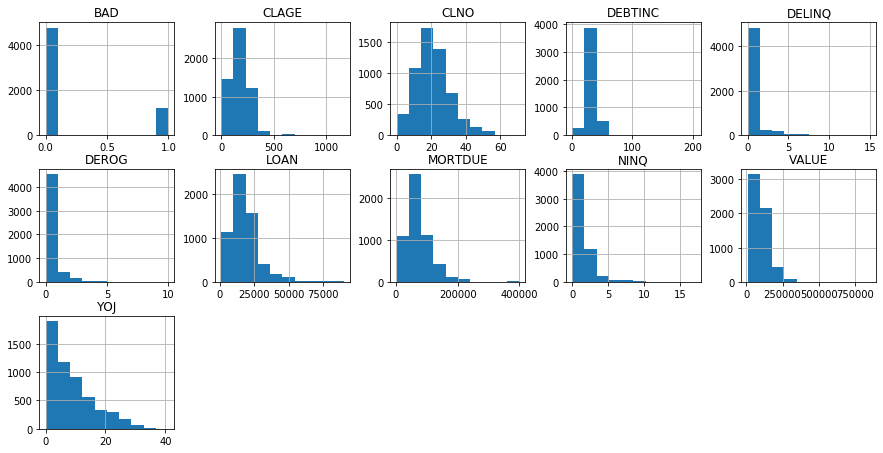

In [4]:
hmeq.hist(figsize=(15,75), layout=(28, 5));

In [5]:
hmeq.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

In [8]:
predictorColumns = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

targetColumn = 'BAD'
x = hmeq[predictorColumns]
y = hmeq[targetColumn]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3, random_state=42)

# For missing values, impute the data set's mean value
xTest.fillna(xTest.mean(), inplace=True)
xTrain.fillna(xTrain.mean(), inplace=True)


In [9]:
treeModel = DecisionTreeClassifier(random_state=42, min_samples_leaf=25)
treeModel = treeModel.fit(xTrain, yTrain)

forestModel = RandomForestClassifier(random_state=42)
forestModel = forestModel.fit(xTrain, yTrain)

gradientModel = GradientBoostingClassifier(random_state=42)
gradientModel = gradientModel.fit(xTrain, yTrain)

In [10]:
def sortFeatureImportance(model, xData):
    features = {}
    for importance, name in sorted(zip(model.feature_importances_, xData.columns), reverse=True):
        features[name] = str(np.round(importance*100, 2)) + '%'
    return features

importances = pd.DataFrame.from_dict(sortFeatureImportance(treeModel, xTrain), orient='index').rename(columns={0: 'DecisionTree'})
importances['RandomForest'] = pd.DataFrame.from_dict(sortFeatureImportance(forestModel, xTrain), orient='index')
importances['GradientBoosting'] = pd.DataFrame.from_dict(sortFeatureImportance(gradientModel, xTrain), orient='index')
importances

,DecisionTree,RandomForest,GradientBoosting
DEBTINC,55.8%,25.29%,49.81%
DELINQ,16.7%,9.45%,13.91%
CLAGE,4.94%,10.77%,7.18%
LOAN,4.69%,9.84%,3.93%
DEROG,4.19%,7.06%,9.41%
CLNO,3.99%,8.31%,4.13%
MORTDUE,3.01%,8.5%,2.46%
NINQ,2.47%,4.77%,3.21%
VALUE,2.15%,9.23%,3.58%
YOJ,2.04%,6.79%,2.38%


In [11]:
yTreePredict = treeModel.predict(xTest)
yTreeProba = treeModel.predict_proba(xTest)
print(confusion_matrix(yTest, yTreePredict))
print(classification_report(yTest, yTreePredict))
print('Decision Tree Model Accuracy = ' + str(np.round(treeModel.score(xTest, yTest)*100,2)) + '%')

[[1350   39]
 [ 274  125]]
              precision    recall  f1-score   support

           0       0.83      0.97      0.90      1389
           1       0.76      0.31      0.44       399

    accuracy                           0.82      1788
   macro avg       0.80      0.64      0.67      1788
weighted avg       0.82      0.82      0.80      1788

Decision Tree Model Accuracy = 82.49%


In [12]:
yForestPredict = forestModel.predict(xTest)
yForestProba = forestModel.predict_proba(xTest)
print(confusion_matrix(yTest, yForestPredict))
print(classification_report(yTest, yForestPredict))
print('Random Forest Model Accuracy = ' + str(np.round(forestModel.score(xTest, yTest)*100,2)) + '%')

[[1387    2]
 [ 222  177]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.93      1389
           1       0.99      0.44      0.61       399

    accuracy                           0.87      1788
   macro avg       0.93      0.72      0.77      1788
weighted avg       0.89      0.87      0.86      1788

Random Forest Model Accuracy = 87.47%


In [13]:
yGradientPredict = gradientModel.predict(xTest)
yGradientProba = gradientModel.predict_proba(xTest)
print(confusion_matrix(yTest, yGradientPredict))
print(classification_report(yTest, yGradientPredict))
print('Gradient Boosting Model Accuracy = ' + str(np.round(gradientModel.score(xTest, yTest)*100,2)) + '%')

[[1389    0]
 [ 284  115]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1389
           1       1.00      0.29      0.45       399

    accuracy                           0.84      1788
   macro avg       0.92      0.64      0.68      1788
weighted avg       0.87      0.84      0.80      1788

Gradient Boosting Model Accuracy = 84.12%


In [15]:
modelPrefix = ['DecisionTreeClassifier', 'RandomForest', 'GradientBoosting']
zipFolder = [Path.cwd() / 'data/DecisionTreeClassifier/',
             Path.cwd() / 'data/RandomForest/',
             Path.cwd() / 'data/GradientBoosting']
model = [treeModel, forestModel, gradientModel]

for (m, prefix, path) in zip(model, modelPrefix, zipFolder):
    pzmm.PickleModel.pickleTrainedModel(_, m, prefix, path)

In [17]:
def writeJSONFiles(data, predict, target, zipFolder, yTrain, modelPrefix):
    J = pzmm.JSONFiles()
    
    # Write input variable mapping to a json file
    J.writeVarJSON(data[predict], isInput=True, jPath=zipFolder)
    
    # Set output variables and assign an event threshold, then write output variable mapping
    outputVar = pd.DataFrame(columns=['EM_EVENTPROBABILITY', 'EM_CLASSIFICATION'])
    outputVar['EM_CLASSIFICATION'] = yTrain.astype('category').cat.categories.astype('str')
    outputVar['EM_EVENTPROBABILITY'] = 0.5 # Event threshold
    J.writeVarJSON(outputVar, isInput=False, jPath=zipFolder)
    
    # Write model properties to a json file
    J.writeModelPropertiesJSON(modelName=modelPrefix,
                               modelDesc='',
                               targetVariable=target,
                               modelType='',
                               modelPredictors=predict,
                               targetEvent=1,
                               numTargetCategories=1,
                               eventProbVar='EM_EVENTPROBABILITY',
                               jPath=zipFolder,
                               modeler='alex')
    
    # Write model metadata to a json file
    J.writeFileMetadataJSON(modelPrefix, jPath=zipFolder)

for (prefix, path) in zip(modelPrefix, zipFolder):
    writeJSONFiles(hmeq, predictorColumns, targetColumn, path, yTrain, prefix)

In [22]:
def writeModelStats(xTrain, yTrain, testProba, yTest, model, target, zipFolder, conn):
    J = pzmm.JSONFiles()
    
    # Calculate train predictions
    trainProba = model.predict_proba(xTrain)
    
    # Assign data to lists of actual and predicted values
    trainData = pd.concat([yTrain.reset_index(drop=True), pd.Series(data=trainProba[:,1])], axis=1)
    testData = pd.concat([yTest.reset_index(drop=True), pd.Series(data=testProba[:,1])], axis=1)
    
    # Calculate the model statistics and write to json files
    J.calculateFitStat(trainData=trainData, testData=testData, jPath=zipFolder)
    J.generateROCLiftStat(target, 1, conn, trainData=trainData, testData=testData, jPath=zipFolder)
    
username = 'username'
password = '*****'
host = 'yoururlhere.com'
sess = Session(host, username, password, protocol='https')
conn = sess.as_swat()

testProba = [yTreeProba, yForestProba, yGradientProba]
for (m, proba, path) in zip(model, testProba, zipFolder):
    writeModelStats(xTrain, yTrain, proba, yTest, m, targetColumn, path, conn)

In [23]:
S = pzmm.ScoreCode()
for (prefix, path) in zip(modelPrefix, zipFolder):
    S.writeScoreCode(x, y, prefix,
                     '{}.predict({})', prefix + '.pickle',
                     pyPath=path)
    zipIOFile = pzmm.ZipModel.zipFiles(_, path, prefix)
    with sess:
        modelReponse = modelRepo.import_model_from_zip(prefix, 'Risk - Home Loan Default', zipIOFile)